# Figure 4, refined lenalidomide UMAP plots

We generated UMAP plots in the notebook for Figure 1, but a few outliers in the 72 hour lenalidomide data that group with bortezomib and make it more difficult to see the effects of lenalidomide at 72 hr. 

In this notebook, we'll refine the lenalidomide UMAP plots to make the figure easier to read.

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
ggrastr: raster plotting for ggplot2  
cowplot: multi-panel plot assembly

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(ggrastr)
quiet_library(cowplot)

In [2]:
out_dir <- "output/figure_4"
if(!dir.exists(out_dir)) { dir.create(out_dir, recursive = TRUE) }

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the UMAP coordinates generated in the Figure 1 notebook.

In [3]:
umap_uuids <- list(
    "6b839963-4455-4df9-9ff8-cf1a06a4535f",
    "4ea7d50e-6499-4833-863b-c019d4715f0d",
    "49e869fb-952f-4927-a7b4-ad13fbcd017d"
)

In [4]:
umap_fres <- cacheFiles(umap_uuids)
umap_files <- list.files(
    paste0("cache/",umap_uuids),
    recursive = TRUE, full.names = TRUE
)

## Build UMAP plots

In [5]:
plot_treat_time <- function(
    plot_df, 
    invx = FALSE, invy = FALSE,
    focus_col = "treatment", focus_grps = NULL,
    drop_bg = FALSE
) {
    if(invx) {
        plot_df$UMAP_1 <- -1 * plot_df$UMAP_1
    }
    if(invy) {
        plot_df$UMAP_2 <- -1 * plot_df$UMAP_2
    }
    
    if(!is.null(focus_grps)) {
        fg_df <- plot_df[plot_df[[focus_col]] %in% focus_grps,]
        bg_df <- plot_df[!plot_df[[focus_col]] %in% focus_grps,]
    } else {
        fg_df <- plot_df
        bg_df <- NULL
    }
    
    p <- ggplot()
    
    if(!is.null(bg_df) & !drop_bg) {
        p <- p + geom_point_rast(
          data = bg_df,
          aes(x = UMAP_1,
              y = UMAP_2,
              color = treatment_color),
          size = 0.1,
          alpha = 0
        )
    }
    
    p <- p +
      geom_point_rast(
          data = fg_df,
          aes(x = UMAP_1,
              y = UMAP_2,
              color = treatment_color),
          size = 0.1
      ) +
      scale_x_continuous("") +
      scale_y_continuous("") +
      scale_color_identity() +
      theme_bw() +
      theme(axis.text = element_blank(),
            axis.ticks = element_blank(),
            panel.grid.minor = element_blank(),
            plot.margin = margin(0,0,0,0))
}
plot_cell_types <- function(
    plot_df, 
    invx = FALSE, invy = FALSE,
    focus_col = "treatment", focus_grps = NULL,
    drop_bg = FALSE
) {
    if(invx) {
        plot_df$UMAP_1 <- -1 * plot_df$UMAP_1
    }
    if(invy) {
        plot_df$UMAP_2 <- -1 * plot_df$UMAP_2
    }
    
    if(!is.null(focus_grps)) {
        fg_df <- plot_df[plot_df[[focus_col]] %in% focus_grps,]
        bg_df <- plot_df[!plot_df[[focus_col]] %in% focus_grps,]
    } else {
        fg_df <- plot_df
        bg_df <- NULL
    }
    
    p <- ggplot()
    
    if(!is.null(bg_df) & !drop_bg) {
        p <- p + geom_point_rast(
          data = bg_df,
          aes(x = UMAP_1,
              y = UMAP_2,
              color = treatment_color),
          size = 0.1,
          alpha = 0
        )
    }
    
    p <- p +
      geom_point_rast(
          data = fg_df,
          aes(x = UMAP_1,
              y = UMAP_2,
              color = cell_type_color),
          size = 0.1
      ) +
      scale_x_continuous("") +
      scale_y_continuous("") +
      scale_color_identity() +
      theme_bw() +
      theme(axis.text = element_blank(),
            axis.ticks = element_blank(),
            panel.grid.minor = element_blank(),
            plot.margin = margin(0,0,0,0))
}

In [6]:
plot_dfs <- map(umap_files, read.csv, row.names = 1)
names(plot_dfs) <- sub("umap_projection_([0-9]+)_.+", "\\1", basename(umap_files))

In [7]:
plot_dfs <- plot_dfs[c("4", "24", "72")]

Trim the outliers from the 72 hour plot

In [8]:
plot_dfs[["72"]] <- plot_dfs[["72"]] %>%
  filter(UMAP_1 < 0) %>%
  sample_n(n())

In [9]:
fg <- c("dmso", "lenalidomide")

In [10]:
treat_plots <- map(plot_dfs, plot_treat_time, focus_grps = fg, drop_bg = TRUE)
type_plots <- map(plot_dfs, plot_cell_types, focus_grps = fg, drop_bg = TRUE)

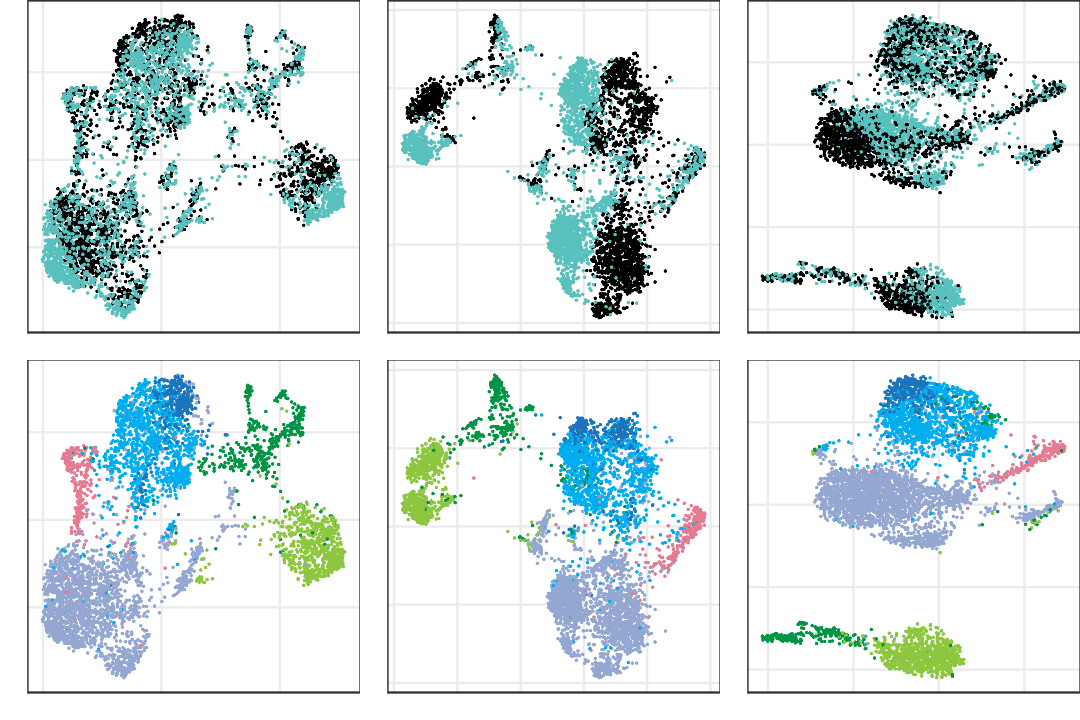

In [11]:
options(repr.plot.width = 9, repr.plot.height = 6)
all_plots <- plot_grid(
    plotlist = c(treat_plots, type_plots),
    nrow = 2, ncol = 3
)
all_plots

In [12]:
out_file <- file.path(out_dir, paste0("umap_plots_lenalidomide_", Sys.Date(), ".pdf"))
ggsave(
    out_file,
    all_plots,
    width = 9, height = 6
)

# Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference.

In [13]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- paste("VRd TEA-seq Fig 4 UMAP", Sys.Date())

In [14]:
out_list <- as.list(out_file)

In [15]:
out_list

[[1]]
[1] "output/figure_4/umap_plots_lenalidomide_2023-10-20.pdf"

In [16]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = umap_uuids,
    store = "project",
    doPrompt = FALSE
)

$files
$files[[1]]
[1] "output/figure_4/umap_plots_lenalidomide_2023-10-20.pdf"


$traceId
[1] "e1dd7c3c-2192-46bd-9148-1fce7edaeab6"

In [17]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_1.1.1 ggrastr_1.0.2 ggplot2_3.4.3 dplyr_1.1.3   purrr_1.0.2  
[6] hise_2.16.0  

loaded via a namespace (and not attached):
 [1] gtable_0.3.4      jsonlite_1.8.7    compiler_4.3.1    crayon_1.5.2     
 [5] tidyselect_1.2.0  IRdisplay_1.1     ggbeeswarm_0.7.2  bitops_1.0-7     
 [9] assertthat_0.2.1  